In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification, AutoTokenizer, get_scheduler, AutoModel
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/kaggle/input/gold-dataset/train_data.csv', sep=',')

In [3]:
test = pd.read_csv('/kaggle/input/gold-dataset/test_data.csv', sep=',')

In [4]:
train.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,694,74.00,Chuyên gia nhận định các yếu tố đang nghiêng v...,15/01/2024,77.00,08:30,Giá vàng hôm nay 15/1: Vàng sẽ tăng lại mức đỉ...,increase
1,638,70.10,Giá vàng giằng co trước những diễn biến khó đo...,02/11/2023,70.80,08:30,"Giá vàng hôm nay 2/11: Đón tin xấu, giá vàng d...",decrease
2,133,54.10,Giá vàng hôm nay ngày 02/12: Sau nhiều diễn bi...,02/12/2020,54.75,08:30,Giá vàng hôm nay ngày 02/12: Giá vàng đột ngột...,increase
3,355,69.55,. Giá vàng năm châu không ngừng cắm đầu lao dố...,20/04/2022,70.25,08:55,"Giá vàng hôm nay 20/4: Hụt hơi, vàng quay đầu ...",decrease
4,55,60.60,Giá vàng lúc 9h34 ngày 7/8/2020 tiếp tục lập đ...,07/08/2020,62.20,10:10,Giá vàng ngày 7/8/2020: lập đỉnh mới trên 62 t...,increase


In [5]:
test.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,595,67.50,“Ngay cả khi vàng và bạc không tăng giá thì ch...,29/08/2023,68.10,09:00,Giá vàng hôm nay 29/8: USD suy yếu giúp vàng b...,increase
1,587,67.00,Hầu hết các nhà phân tích đều cho rằng giá vàn...,19/08/2023,67.70,08:20,"Giá vàng hôm nay 19/8: Áp lực bủa vây, vàng ch...",decrease
2,543,66.35,Nhà phân tích thị trường cấp cao Edward Moya c...,28/06/2023,66.95,14:15,"Giá vàng hôm nay 28/6: Tiếp tục đi xuống, có n...",decrease
3,644,69.30,"Hiện tại, thị trường đang chờ đợi bài phát biể...",10/11/2023,70.30,08:35,Giá vàng hôm nay 10/11: Tăng nhẹ chờ thời,decrease
4,487,66.65,Giá vàng đã có lúc giảm sâu xuống ngưỡng 1.944...,28/03/2023,67.35,09:05,"Giá vàng hôm nay 28/3: Dân buôn chốt lời, vàng...",decrease


In [17]:
def get_config():
    config = {'batch_size': 8,
              'model_name': 'uitnlp/CafeBERT',
              'lr': 2 * (10 ** -5),
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 256,
              'eos': '[SEP]'
              
    }
    return config 

In [18]:
config = get_config()

### Creating dataset

In [8]:
class get_dataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.titles = df['TITLE'].values
        self.content = df['CONTENT'].values
        self.labels = df['labels'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        content = self.content[idx]
        if self.labels[idx] == "increase":
            label = 1
        elif self.labels[idx] == "decrease":
            label = 0
        input_data = title + '[SEP]' + content

        return input_data, label

In [9]:
train_dataset = get_dataset(df=train)
test_dataset  = get_dataset(df=test)

In [10]:
train_dataset[226]

('Giá vàng ngày 28/7/2020: vàng lên 58 triệu, cao nhất mọi thời đại[SEP]Giá vàng lúc 9h25 ngày 28/7/2020 lên mức 58 triệu/lượng, cao nhất mọi thời đại, với mức tăng từ 700.000 đến 1.400.000 so với hôm qua. Chênh lệch mua vào bán ra giao động từ 1.420.000 đến 1.800.000 đồng/lượng.\r\nGiá vàng trong nước\r\n\r\n\r\nGiá vàng tại công ty VBĐQ Sài Gòn mua vào bán ra lần lượt là 56.400.000 và 58.020.000/lượng, tăng 950.000/lượng chiều mua và 1.100.000/lượng chiều bán. Giá chênh lệch mua bán là 1.420.000/lượng. Trong khi đó, giá vàng nhẫn SJC 0,5 chỉ mua vào 54.000.000/lượng và bán ra 55.100.000/lượng\r\nTại hệ thống Bảo Tín Minh Châu, giá vàng niêm yết ở mức 56.550.000/lượng mua vào (tăng 1.150.000/lượng) và bán ra ở mức 58.000.000/lượng (tăng 1.350.000/lượng). Chênh lệch mua vào bán ra là 1.450.000/lượng. Cùng thời điểm này, vàng miếng Vàng Rồng Thăng Long giao dịch ở mức 54.460.000 - 55.860.000/lượng (mua vào - bán ra)\r\nTại PNJ, giá vàng tăng 1.100.000/lượng chiều mua lên mức 56.350.000/

In [11]:
def create_dataloader(dataset: Dataset, config: dict, is_train: bool) -> DataLoader:

    return DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=is_train, drop_last=is_train) 

In [12]:
train_loader = create_dataloader(train_dataset, config, True)
test_loader  = create_dataloader(test_dataset, config, False)

### Training

In [13]:
config['model_name']

'uitnlp/CafeBERT'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

tokenizer_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

### Training

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create model
model = RobertaForSequenceClassification.from_pretrained(config['model_name'], num_labels=config['num_labels'])

# create optimizer
optimizer = AdamW(params=model.parameters(), lr=config['lr'])

train_loader = create_dataloader(train_dataset, config, True)
test_loader = create_dataloader(test_dataset, config, False)

num_training_steps = config['epochs'] * len(train_loader)
# create lr scheduler
lr_scheduler = get_scheduler(
    'cosine', optimizer=optimizer, num_warmup_steps=config['num_warmup_steps'], num_training_steps=num_training_steps
)

# create loss function
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)
epochs = config['epochs']

# Early stopping parameters
patience = 2
best_eval_loss = float('inf')
early_stopping_counter = 0

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# training
print("========== Start training ==========")
for epoch in range(epochs):
    model.train()
    training_loss = 0
    for inputs, labels in train_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        labels = labels.to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    training_loss /= len(train_loader)

    # testing
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

    eval_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Training loss: {training_loss:.4f}, Eval loss: {eval_loss:.4f}")

    # Check for early stopping
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

print("========== End training ==========")

========== Start training ==========
Epoch 1, Training loss: 3.5414, Eval loss: 2.9979
Epoch 2, Training loss: 3.2513, Eval loss: 0.7165
Epoch 3, Training loss: 1.8161, Eval loss: 0.8728
Epoch 4, Training loss: 1.0920, Eval loss: 0.6895
Epoch 5, Training loss: 1.2536, Eval loss: 0.7228
========== End training ==========


### Inference

In [20]:
preds = []

In [21]:
model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted_labels = torch.max(probs, dim=1)
        preds.extend(predicted_labels.detach().cpu().tolist()) 

In [22]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [23]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [24]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.4551
Precision : 0.4551
Recall    : 1.0000
F1 Score  : 0.6256


Confusion metrics

Confusion matrix is: [[ 0 85]
 [ 0 71]]


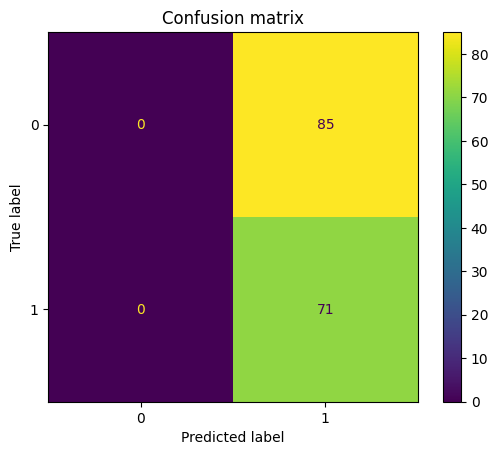

In [25]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()